<a href="https://colab.research.google.com/github/pawelrat009/ML2025-1/blob/main/projekt_CNN_v4_test1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Projekt z przedmiotu: Sieci neuronowe i ich zastosowania

Splotowe sieci neuronowe wykorzytane do identyfikacji gatunków i chorób liści z bazy PlantVillage

Autorzy:
* Tomasz Kaczarek
* Mateusz Liberda
* Paweł Ratajczak

Wykorzystna baza dnaych: PlantVillage: https://www.kaggle.com/datasets/mohitsingh1804/plantvillage



https://gemini.google.com/share/4f1520b853d9

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [19]:
def Show_history(history, epochs):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8,8))
  plt.subplot(1,2,1)
  plt.plot(epochs_range, acc, label="Training accuracy")
  plt.plot(epochs_range, val_acc, label="Validation accuracy")
  plt.legend(loc='lower right')
  plt.title('Training and validation accuracy')

  plt.subplot(1,2,2)
  plt.plot(epochs_range, loss, label="Training loss")
  plt.plot(epochs_range, val_loss, label="Validation loss")
  plt.legend(loc="upper right")
  plt.title("Training and validation losses")
  plt.show()

In [20]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mohitsingh1804/plantvillage")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'plantvillage' dataset.
Path to dataset files: /kaggle/input/plantvillage


In [21]:
import pathlib
data_dir = pathlib.Path(path)

# Assuming dataset content inside subdirectory
data_dir = data_dir / 'PlantVillage'

In [22]:
# sprawdzenie ścieżki i zawartośći folderu
import os

# Let's see what folders are actually there
print(f"Checking path: {data_dir}")
if data_dir.exists():
    print("Folders found:", os.listdir(data_dir))
else:
    print("The path does not exist. Check the kagglehub download output.")

Checking path: /kaggle/input/plantvillage/PlantVillage
Folders found: ['val', 'train']


In [23]:
import pathlib
import tensorflow as tf

# 1. Ustawienie ścieżek na podstawie Twojej struktury

train_dir = data_dir / 'train'
val_dir = data_dir / 'val'

In [24]:
# 2. Ładowanie zbioru TRENINGOWEGO (wszystkie pliki z folderu train)
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode='int',
    image_size=(128, 128),
    batch_size=16,
    shuffle=True
)
# 3. Ładowanie zbioru WALIDACYJNEGO (wszystkie pliki z folderu val)
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    label_mode='int',
    image_size=(128, 128),
    batch_size=16,
    shuffle=False # Przy walidacji/testach nie musimy mieszać kolejność
)

class_names = train_ds.class_names
print(f"Dane załadowane! Trening: {len(train_ds)} batchy, Walidacja: {len(val_ds)} batchy.")

Found 43444 files belonging to 38 classes.
Found 10861 files belonging to 38 classes.
Dane załadowane! Trening: 2716 batchy, Walidacja: 679 batchy.


In [25]:
# Wyświetlenie mapowania klas
# TO DELETE?
class_names = train_ds.class_names
print(f"Wykryte klasy: {class_names}")

Wykryte klasy: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tom

In [26]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#     for i in range(8):
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(train_ds.class_names[labels[i]])
#         plt.axis("off")

In [27]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [28]:
# odchudzony
from tensorflow.keras import layers, Sequential
import tensorflow as tf

num_classes = len(class_names)

model = Sequential([
    layers.Input(shape=(128, 128, 3)),
    layers.Rescaling(1./255),

    # Zaczynamy od małej liczby filtrów - 16 zamiast 64
    layers.Conv2D(16, (3,3), padding="same", activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(32, (3,3), padding="same", activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(32, (3,3), padding="same", activation='relu'),
    layers.MaxPooling2D((2,2)),

    # GlobalAveragePooling2D zamienia mapy cech na jeden wektor bez obciążania RAM
    layers.GlobalAveragePooling2D(),

    layers.Dense(32, activation='relu'), # Mała warstwa ukryta
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 38)             │         1,254 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,646 (65.02 KB)

 Trainable params: 16,646 (65.02 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# from tensorflow.keras import layers, Sequential

# num_classes = len(class_names) # Automatycznie pobierze liczbę folderów (np. 38)

# model = Sequential([
#     # Warstwa wejściowa dopasowana do danych
#     layers.Input(shape=(244, 244, 3)),

#     # Augmentacja
#     layers.RandomFlip("horizontal"),
#     layers.RandomRotation(0.1),
#     layers.RandomZoom(0.1),

#     # Skalowanie pikseli
#     layers.Rescaling(1./255),

#     # Twoja architektura splotowa
#     layers.Conv2D(64, (3,3), padding="same", activation='relu'),
#     layers.MaxPooling2D((2,2)),

#     layers.Conv2D(32, (6,6), padding="same", activation='relu'),
#     layers.MaxPooling2D((2,2)),

#     layers.Conv2D(32, (3,3), padding="same", activation='relu'),
#     layers.MaxPooling2D((2,2)),

#     layers.Conv2D(128, (5,5), padding="same", activation='relu'),
#     layers.MaxPooling2D((3,3)),

#     # Klasyfikacja
#     #layers.Flatten(),
#     layers.GlobalAveragePooling2D(),
#     layers.Dense(128, activation='relu'),
#     layers.Dense(num_classes, activation='softmax')
# ])

# model.compile(
#     optimizer='adam',
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#     metrics=['accuracy']
# )

# model.summary()

In [30]:
epochs = 20

# EarlyStopping to "bezpiecznik" - zatrzyma naukę, gdy model przestanie robić postępy
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[callback]
)

Epoch 1/20
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 79s 21ms/step - accuracy: 0.2385 - loss: 2.8119 - val_accuracy: 0.4486 - val_loss: 1.8939
Epoch 2/20
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.4848 - loss: 1.7331 - val_accuracy: 0.5214 - val_loss: 1.5743
Epoch 3/20
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - accuracy: 0.6047 - loss: 1.3299 - val_accuracy: 0.6637 - val_loss: 1.1305
Epoch 4/20
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.6688 - loss: 1.0805 - val_accuracy: 0.6834 - val_loss: 1.0480
Epoch 5/20
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - accuracy: 0.7057 - loss: 0.9493 - val_accuracy: 0.7231 - val_loss: 0.8996
Epoch 6/20
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.7369 - loss: 0.8471 - val_accuracy: 0.7489 - val_loss: 0.8138
Epoch 7/20
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.7659 - loss: 0.7543 - val_accuracy: 0.7603 - val_loss: 0.7987
Epoch 8/20
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.7825 - loss: 

In [31]:
#history  = model.fit(train_ds, validation_data=val_ds, epochs=3)

In [32]:
# print(class_names)
# obraz = 23

# for images, labels in validation_ds.take(1):
#     plt.imshow(images[obraz].numpy().astype("uint8"))
#     plt.title(class_names[labels[obraz]])
#     plt.axis("off")

# predictions = model.predict(validation_ds.take(1))
# print(np.round(predictions[obraz],2))

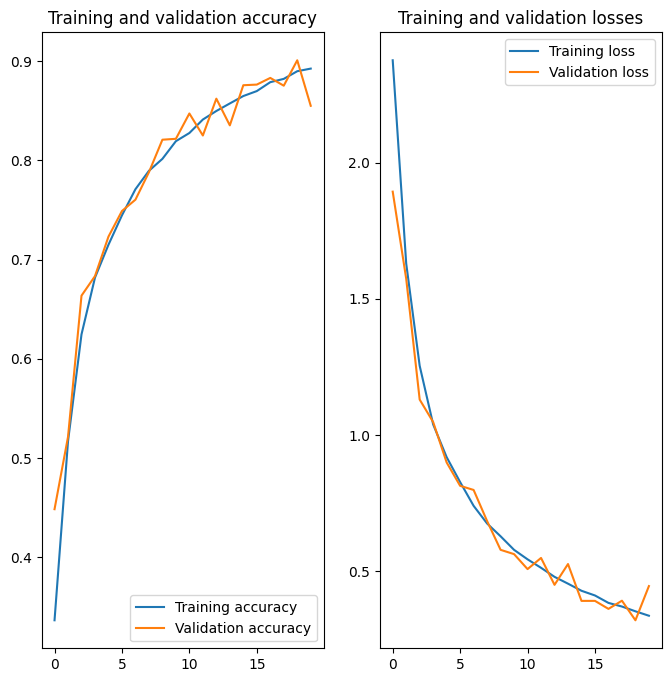

In [33]:
Show_history(history, epochs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━

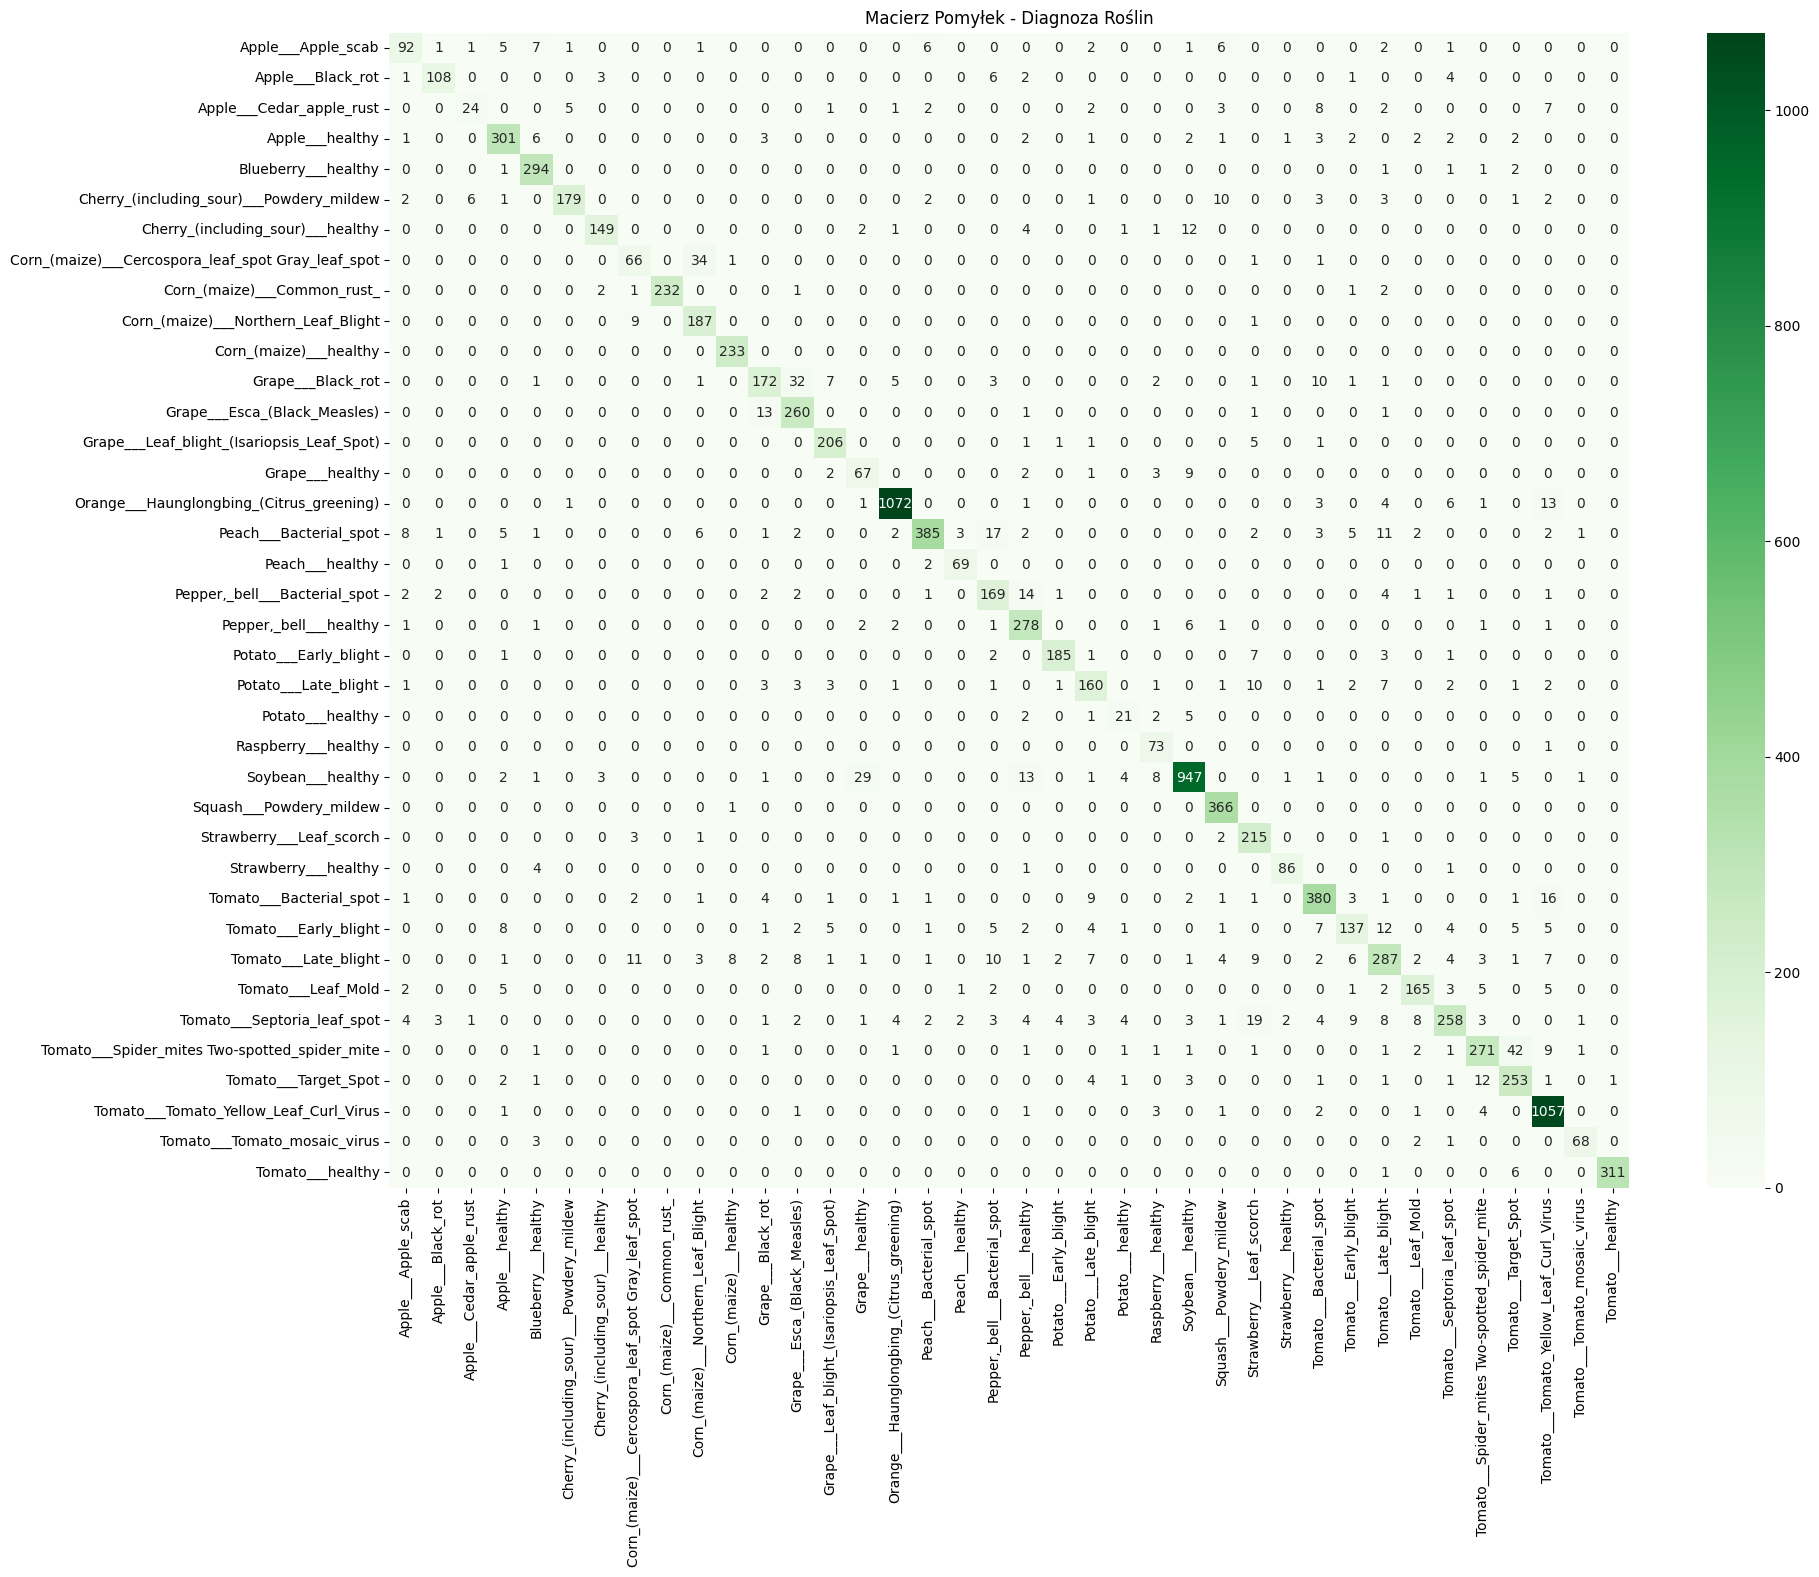

In [34]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def show_confusion_matrix(model, val_ds):
    y_true = []
    y_pred = []

    for x, y in val_ds:
        predictions = model.predict(x)
        y_true.extend(y.numpy())
        y_pred.extend(np.argmax(predictions, axis=1))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(20, 15))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Greens',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Macierz Pomyłek - Diagnoza Roślin')
    plt.show()

# Wywołanie po treningu:
show_confusion_matrix(model, val_ds)